In [1]:
import numpy as np
import import brighteyes_flim as flim
import matplotlib.pyplot as plt
from scipy.signal import convolve
import os
import math
import brighteyes_ism.simulation.PSF_sim as sim
import brighteyes_ism.analysis.Graph_lib as gra
import brighteyes_ism.analysis.Tools_lib as tool
import brighteyes_ism.analysis.Deconv_lib as dec
import brighteyes_ism.analysis.FRC_lib as frc
from skimage.filters import gaussian
import brighteyes_ism.simulation.Tubulin_sim as simTub

from s2ISM_unmixing.s2ISM.src.s2ism import s2ism as s2

import sys

import brighteyes_ism.analysis.APR_lib as apr

import brighteyes_ism.dataio.mcs as mcs

# %%
#import brighteyes_flim as flim
from skimage.registration import phase_cross_correlation
from scipy.ndimage import shift
import scipy.signal
from skimage.filters import gaussian

### IRF: calibration with solution of Rhodamine B in methanol

In [4]:
#"\\iitfsvge101.iit.local\mms\Data MMS server\STED-ISM\IRF calibration Rhodamine B\40 MHZ INT\calibration.h5"
data_irf, meta_irf = mcs.load(r"/mnt/iitfsvge101/MMS/Data MMS server/STED-ISM/IRF calibration Rhodamine B/40 MHZ INT/validation.h5")

data_irf = tool.CropEdge(data_irf, npx=10, edges='lrud', order = 'rzxytc')
#data = tools.DownSample(data, ds = 2, order = 'rzxytc')

In [5]:
print('Dataset IRF shape: ' + str(data_irf.shape) + '\n')
meta_irf.Print()

Dataset IRF shape: (1, 1, 492, 492, 91, 25)

version       0.0.1
comment       
rangex        20.439999999999998
rangey        20.439999999999998
rangez        0.0
nbin          91
dt            0.2
nx            512
ny            512
nz            1
nrep          1
calib_x       17.303
calib_y       17.409
calib_z       4.75


In [7]:
data_irf_4D = data_irf.sum((0,1))
print(data_irf_4D.shape)

(492, 492, 91, 25)


In [20]:
data_hist_irf = data_irf.sum(axis = (0, 1, 2, 3))
print(data_hist_irf.shape)

(91, 25)


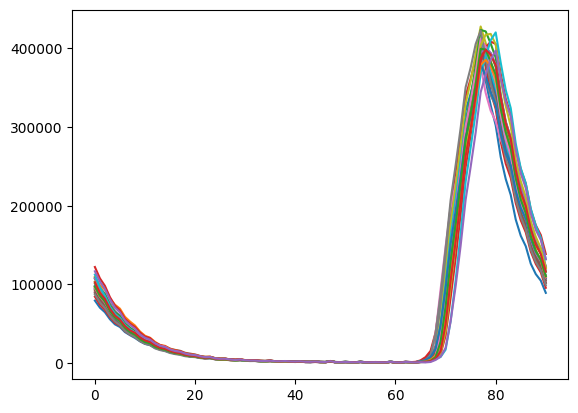

In [21]:
plt.figure()
for i in range(25):
    plt.plot(data_hist_irf[:,i])

### alignment: if you want to aligne the decay histograms of the 25 SPAD channels, you can use the align_decays function after computing the temporal shifts along the time bins using the function find_temporal_shifts

In [9]:
shift_vec_calib = flim.find_temporal_shifts(data_irf_4D)
print(shift_vec_calib.shape)

(25,)


/tmp/ipykernel_1772952/144086192.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  shift_vec[i], *_ = phase_cross_correlation(data_hist[:, 12], data_hist[:, i], upsample_factor=100, normalization=None)


In [13]:
decays_aligned = flim.align_decays(data_irf_4D, shift_vec_calib)

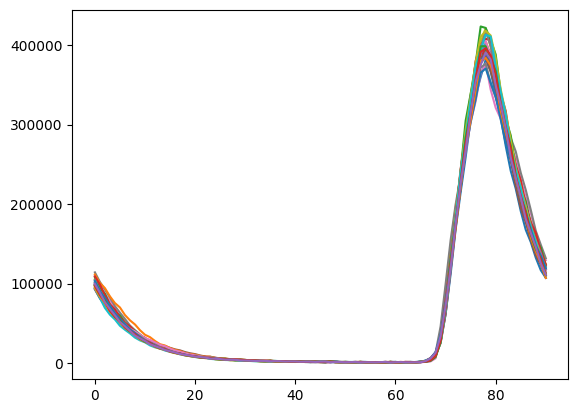

In [15]:
plt.figure()
for i in range(25):
    plt.plot(decays_aligned[:,i])

### alignment: if you want to aligne the decay histograms in each pixel of the 25 SPAD channels, you can use the align_image function after computing the temporal shifts along the time bins using the function find_temporal_shifts

In [12]:
image_calib_aligned = flim.align_image(data_irf_4D, shift_vec_calib)

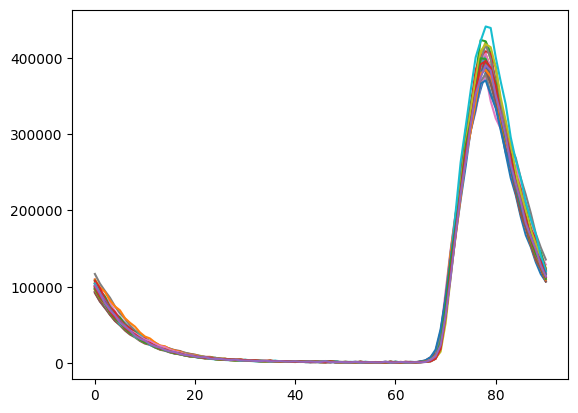

In [16]:
image_calib_aligned_sum = image_calib_aligned.sum((0,1))
plt.figure()
for i in range(25):
    plt.plot(image_calib_aligned_sum[:,i])

### IRF calibration with phasors: clean the IRF from the measured phasor of a sample

### Load a dataset of rhodamine B different from the one used to calibrate the IRF

In [17]:
data_cellm, meta_cellm = mcs.load(r'/mnt/iitfsvge101/MMS/Data MMS server/STED-ISM/IRF calibration Rhodamine B/40 MHZ INT/calibration.h5')
data_cellm = tool.CropEdge(data_cellm, npx=10, edges='lrud', order = 'rzxytc')
#data = tools.DownSample(data, ds = 2, order = 'rzxytc')
pxsizex_cellm = meta_cellm.dx
print(pxsizex_cellm)

0.039921874999999996


In [18]:
print('Dataset shape: ' + str(data_cellm.shape) + '\n')
meta_cellm.Print()

Dataset shape: (1, 1, 492, 492, 91, 25)

version       0.0.1
comment       
rangex        20.439999999999998
rangey        20.439999999999998
rangez        0.0
nbin          91
dt            0.2
nx            512
ny            512
nz            1
nrep          1
calib_x       17.303
calib_y       17.409
calib_z       4.75


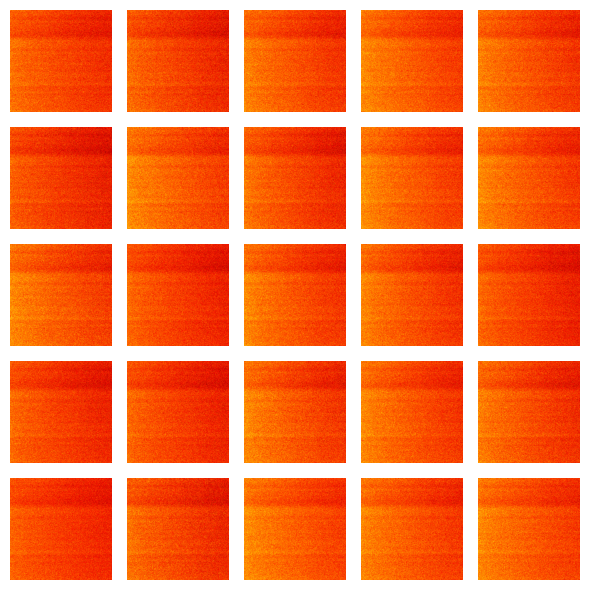

In [19]:
dset_cellm = data_cellm.sum(axis = (0, 1, 4))
fig = gra.ShowDataset(dset_cellm)

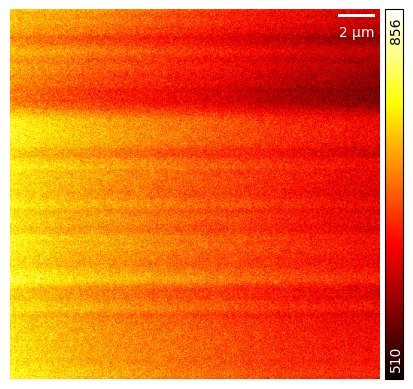

In [20]:
fig_cellm = gra.ShowImg(dset_cellm.sum(-1), pxsizex_cellm)

In [21]:
rhod_data = data_cellm.sum(axis = (0,1))
print(rhod_data.shape)

(492, 492, 91, 25)


(492, 492, 25)


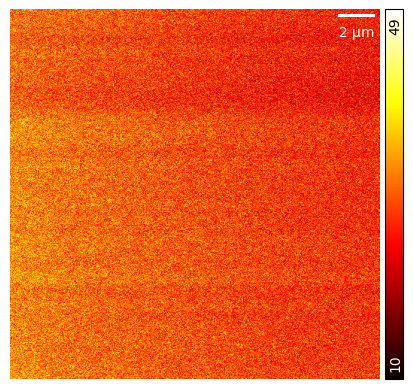

In [42]:
rhod_data_xyc = rhod_data.sum(-2)
print(rhod_data_xyc.shape)
fig_cellm = gra.ShowImg(rhod_data_xyc[:,:,12], pxsizex_cellm)

In [43]:
hists_rhod = data_cellm.sum(axis = (0, 1,2,3))
print(hists_rhod.shape)

(91, 25)


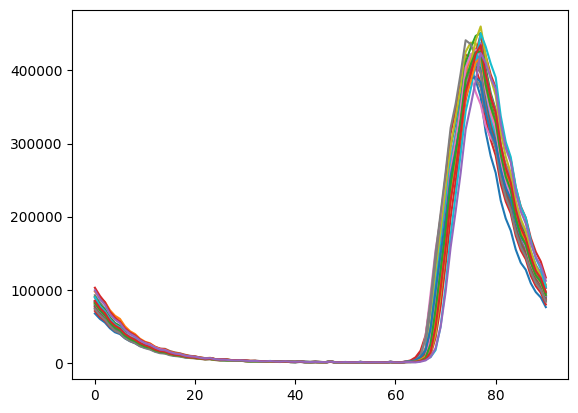

In [44]:
plt.figure()
for i in range(25):
    plt.plot(hists_rhod[:,i])

### Lifetime estimation of the analyzed solution of Rhodamine B through phasor analysis and IRF calibration are performed within the method calibrate_phasor 

#### estimation on the sum of all the SPAD channels

In [26]:
phasors_pixels_calibrated = flim.calibrate_phasor(rhod_data, data_irf_4D, tau_m_reference=2.5*10**-9, tau_phi_reference=2.5*10**-9, processing='Open confocal')
print(phasors_pixels_calibrated.shape)

/tmp/ipykernel_1772952/3609268457.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  shift_vec[i], *_ = phase_cross_correlation(data_hist_irf[:,i], data_hist_input[:,i], upsample_factor=100, normalization=None)
/tmp/ipykernel_1772952/3609268457.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  shift_vec[i], *_ = phase_cross_correlation(data_hist[:, 12], data_hist[:, i], upsample_factor=100, normalization=None)


(492, 492)


(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='g', ylabel='s'>)

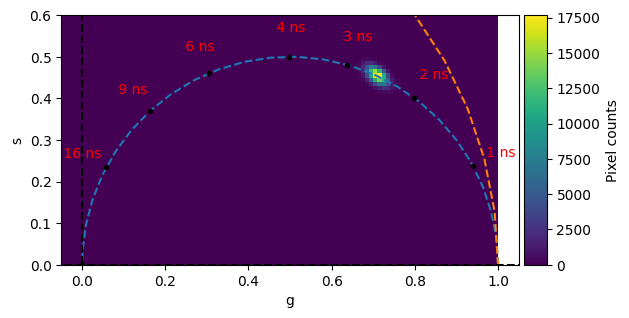

In [27]:
flim.plot_phasor(phasors_pixels_calibrated, bins_2dplot=200, log_scale=False, quadrant='first', dfd_freq = 40e6)

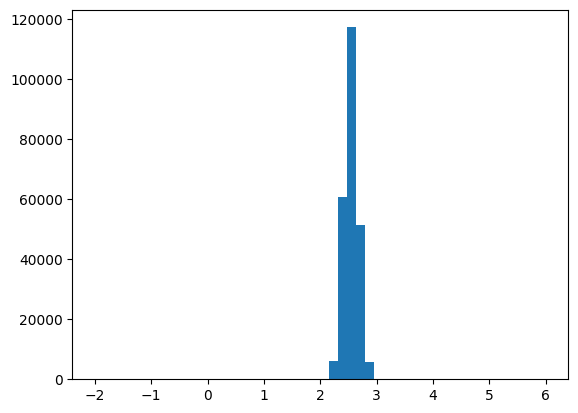

In [28]:
flim.show_lifetime_histogram(phasors_pixels_calibrated)

#### estimation on the 12th SPAD channel

In [29]:
phasors_pixel12_calibrated = flim.calibrate_phasor(rhod_data, data_irf_4D, ch=12, tau_m_reference=2.5*10**-9, tau_phi_reference=2.5*10**-9, processing='Single channel')
print(phasors_pixel12_calibrated.shape)

/tmp/ipykernel_1772952/3609268457.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  shift_vec[i], *_ = phase_cross_correlation(data_hist_irf[:,i], data_hist_input[:,i], upsample_factor=100, normalization=None)


(492, 492)


(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='g', ylabel='s'>)

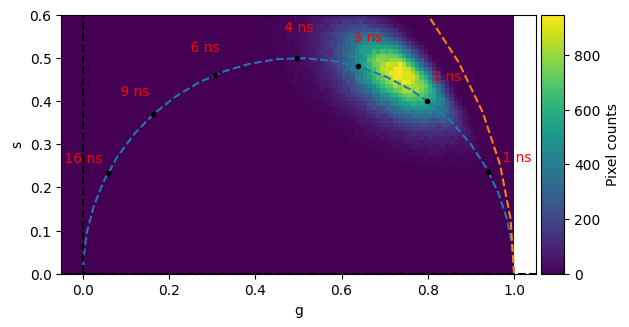

In [30]:
flim.plot_phasor(phasors_pixel12_calibrated, bins_2dplot=200, log_scale=False, quadrant='first', dfd_freq = 40e6)

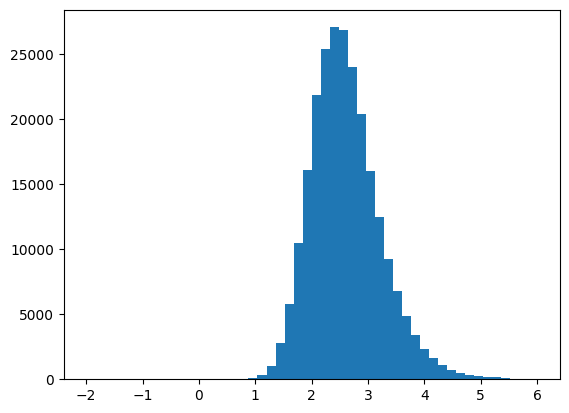

In [31]:
flim.show_lifetime_histogram(phasors_pixel12_calibrated)